In [37]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn_pandas import DataFrameMapper
from sklearn_pandas import CategoricalImputer
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing.imputation  import Imputer
from sklearn.preprocessing  import StandardScaler,LabelBinarizer
from sklearn.metrics import roc_curve, auc, f1_score,classification_report,roc_auc_score,precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

pd.set_option('display.max_colwidth', -1)

In [38]:
df = pd.read_parquet("/home/adam/bigdata/dane/codereview/stack_table.parquet")

df = df.drop(['AcceptedAnswerId','CreationDate','OwnerUserId','codesnippet'],axis=1)  
df['no_sentences_body'] = df['no_sentences_body'].astype('int')
df['no_words_body'] = df['no_words_body'].astype('int')
df['no_signs_body'] = df['no_signs_body'].astype('int')
df['no_digits_body'] = df['no_digits_body'].astype('int')
df['pct_answers_to_questions'] = df['No_of_answers'] / df['No_of_questions']
df['pct_class1'] = df['class1'] / df[['class1', 'class2','class3']].sum(axis=1)
df['pct_class2'] = df['class2'] / df[['class1', 'class2','class3']].sum(axis=1)
df['pct_class3'] = df['class3'] / df[['class1', 'class2','class3']].sum(axis=1)

df['Flag_'+'Time_from_last_question'+'_missing'] = df['Time_from_last_question'].isnull().astype('int')
df[['Flag_Location','Flag_AboutMe','Flag_WebsiteUrl','Time_from_last_question', 'pct_class3','pct_class2','pct_class1']] = df[['Flag_Location','Flag_AboutMe','Flag_WebsiteUrl','Time_from_last_question', 'pct_class3','pct_class2','pct_class1']].fillna(value=0)
df.loc[~df.UserContinent.isin(['Brak','EU','NA','SA','AS','OC','AF']),'UserContinent'] = np.nan
#df.set_index('Id',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55105 entries, 0 to 55104
Data columns (total 53 columns):
Id                                      55105 non-null int32
Reputation                              54088 non-null float64
UserLocation                            27685 non-null object
UserCountry                             55105 non-null object
UserAlpha2                              23789 non-null object
UserContinent                           53097 non-null object
Flag_Location                           55105 non-null float64
Flag_AboutMe                            55105 non-null float64
Flag_WebsiteUrl                         55105 non-null float64
Seniority                               54088 non-null float64
OwnerUserId_Null                        55105 non-null int32
Time_from_last_question                 55105 non-null float64
No_of_questions_last_year               55105 non-null int64
No_of_questions                         55105 non-null int32
Title                

In [39]:
text_columns = ['body_cleaned2']
categorical_feature_mask = df.dtypes == object
categorical_columns = df.columns[categorical_feature_mask].tolist()
non_categorical_columns = df.columns[~categorical_feature_mask ].tolist()
categorical_columns = list(set(categorical_columns) - set(text_columns))
print(categorical_columns)
#print(text_columns)
#print(non_categorical_columns)



X = df[df.columns.difference(['Target'])]
y = df['Target']
#cols1 = df.columns.difference(['Target']).tolist() + ['Target']
# print(y.columns)
# print(X.columns)
#df = df[cols1]
#df.info()
#cols = cols1.append('Target')
#print(cols)
#X = df.iloc[:,:-1]
#y = df.iloc[:,-1]
#non_categorical_columns = ['Id','No_of_answers','No_of_comments','class1', 'class2','no_of_tags']  
#X = df[non_categorical_columns]
#y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size=0.2, random_state=100)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
#df[['Body','body_cleaned','body_cleaned2','Target']].head(30)
#df[['Body','body_cleaned','body_cleaned2','Title','UserLocation','UserCountry','UserContinent','Tags','tag_cleaned','language','Target']].head(60)
#df1 = df[['Body','body_cleaned','body_cleaned2','Title','Target']]
#df2 = df[['UserLocation','UserCountry','UserContinent','Tags','language','Target']]
#df1.to_excel('/home/adam/bigdata/dane/codereview/body.xlsx')
#df2.to_excel('/home/adam/bigdata/dane/codereview/location.xlsx')


['body_cleaned', 'UserAlpha2', 'UserContinent', 'UserCountry', 'tag_cleaned', 'Title', 'Tags', 'first_tag', 'language', 'UserLocation', 'Body']
(44084, 52)
(44084,)
(11021, 52)
(11021,)


In [40]:
from scipy.sparse import csr_matrix, hstack

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self,columns=None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self
    def transform(self, X):                                                           
        return X[self.columns]
    def get_feature_names(self):
        return self.columns

    
    
class DictifierConverter(BaseEstimator, TransformerMixin):       
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.to_dict('records') 
    
# class SparseConverter(BaseEstimator, TransformerMixin):       
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         print(X.T.shape)
#         print(csr_matrix(np.matrix(X)).shape)
#         return csr_matrix(np.matrix(X))     
    
class ArrayCaster(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, data):
        print(data.shape)
        print(np.matrix(data).shape)
        return np.matrix(data)    
    
class SparseConverter(BaseEstimator, TransformerMixin):       
    def __init__(self,columns=None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
         return self
    def transform(self, X):                                                           
        return X[self.columns].values
    
    
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
# print( ENGLISH_STOP_WORDS)
stopwords = ENGLISH_STOP_WORDS.union(['can\'t','i\'m','don\'t','does','you\'re','shouldn\'t','ve','don','ll','i\'ll','gt','aaaa','aaab','aa','aaa','ab'])    
    

In [41]:
#1 Body + CV

num_pipeline = Pipeline([
          ('selector',ColumnSelector(columns=['Flag_Time_from_last_question_missing','Flag_AboutMe','No_of_answers','No_of_comments','class3','no_of_tags','Up','no_signs_body','Reputation'] )),
                ('imputer',Imputer(strategy = 'mean')), 
                ('std_scaler',StandardScaler()),
#                  ('sparse',ArrayCaster()),
                ])   
#num_pipeline.fit_transform(X_train)
    


cat_pipeline = Pipeline([
               ('selector',ColumnSelector(columns = ['UserContinent'])), 
               ('dictifier',DictifierConverter()),       
               ('vectorizer',DictVectorizer(sparse = False)),
                ('imputer',Imputer(strategy = 'most_frequent')), 
#                ('sparse',ArrayCaster()),
             
               ])


txt_body_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='body_cleaned2')),
 

                       ('tfidf', CountVectorizer(stop_words=stopwords,  min_df=5, max_df=0.7,max_features =5)),
#                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
#                        ('sparse',ArrayCaster()),
                       ])

# txt_tag_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='tag_cleaned')),
 

#                        ('tfidf', CountVectorizer( min_df=5)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])
# txt_title_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='Title')),
 

#                        ('tfidf', CountVectorizer( min_df=5)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])


#txt_pipeline.fit_transform(X_train)
full_pipeline = FeatureUnion(transformer_list =[
                ('num_pipeline', num_pipeline),
#                 ('cat_pipeline', cat_pipeline),
                ('txt_body_pipeline', txt_body_pipeline),
#                 ('txt_tag_pipeline', txt_body_pipeline),
#                 ('txt_title_pipeline', txt_title_pipeline),
  
])

#full_pipeline.fit_transform(X_train)
pipeline_1 = Pipeline([
                ('union',full_pipeline),
#                 ('clf',RandomForestClassifier(max_depth=3,n_estimators=50)),
                ('clf',GradientBoostingClassifier()),
    
   
])






tuned_parameters = [
#                 {
#                 'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_body_pipeline__tfidf__max_features':[3,5,15],
#                 'clf':[LogisticRegression()],
#                 'clf__C': [0.1,1, 10, 100],
#                 'clf__penalty': ['l1', 'l2'],
#                 },
#                 {
#                  'union__txt_body_pipeline__tfidf__ngram_range':[(1,1)],
#                  'union__txt_body_pipeline__tfidf__max_features':[3,5,15],
#                 'clf': [GradientBoostingClassifier()],
#                 'clf__n_estimators': [50,100,150],
#                 'clf__max_depth': [3,6,8,12],
#                 'clf__learning_rate': [0.1],
#                 },
#                 {
#                  'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_body_pipeline__tfidf__max_features':[3,5,15],
#                 'clf': [RandomForestClassifier()],
#                 'clf__n_estimators': [50,100,250,500],
#                 'clf__max_depth': [5,8,16,32],
#                 'clf__max_features': [5,10,15,20],
#                 },
                {
                'union__txt_body_pipeline__tfidf__ngram_range':[(1,1),(1,2) ],
                 'union__txt_body_pipeline__tfidf__max_features':[5,15],
                'clf': [XGBClassifier()],
#                  'clf__subsample': [0.9],
#                 'clf__max_depth': [5,10,15],
                'clf__n_estimators': [100,250,500],
                'clf__learning_rate':[0.1],  
#                 'clf__min_child_weight': [4,6],
#                  'clf__colsample_bytree': [0.5,0.7,0.9],
                },
               # {'estimator':[Any_other_estimator_you_want],
               #  'estimator__valid_param_of_your_estimator':[valid_values]

              ]

#print(pipeline.get_params().keys())
# tuned_parameters = [{'union__txt_pipeline__tfidf__ngram_range':[(1,2),(1,1)],
#                      'clf__n_estimators':[10,50,100]}]

CV_clf_1 = GridSearchCV(pipeline_1,param_grid = tuned_parameters,cv=3,scoring='roc_auc',n_jobs=-1,return_train_score=True)
CV_clf_1.fit(X_train,y_train)

# print('Grid best parameter (max. AUC): ', CV_clf.best_params_)
# print('Grid best score (AUC): ', CV_clf.best_score_)
# print( CV_clf)
#CV_clf.grid_scores_
clf_1 = CV_clf_1.cv_results_


# pipeline.fit(X_train,y_train)
# y_pred =  pipeline.predict(X_test)
# print(classification_report(y_test, y_pred,digits=3))
   
    

In [42]:
#2 Tag + CV

num_pipeline = Pipeline([
        ('selector',ColumnSelector(columns=['Flag_Time_from_last_question_missing','Flag_AboutMe','No_of_answers','No_of_comments','class3','no_of_tags','Up','no_signs_body','Reputation'] )),
                ('imputer',Imputer(strategy = 'mean')), 
                ('std_scaler',StandardScaler()),
#                  ('sparse',ArrayCaster()),
                ])   
num_pipeline.fit_transform(X_train)
    


cat_pipeline = Pipeline([
               ('selector',ColumnSelector(columns = ['UserContinent'])), 
               ('dictifier',DictifierConverter()),       
               ('vectorizer',DictVectorizer(sparse = False)),
                ('imputer',Imputer(strategy = 'most_frequent')), 
#                ('sparse',ArrayCaster()),
             
               ])


# txt_body_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='body_cleaned')),
 

#                        ('tfidf', CountVectorizer(stop_words=stopwords,  min_df=5, max_df=0.7, max_features=100)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])

txt_tag_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='tag_cleaned')),
 

                       ('tfidf', CountVectorizer( min_df=5, analyzer="word",max_features=5)),
#                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
#                        ('sparse',ArrayCaster()),
                       ])
# txt_title_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='Title')),
 

#                        ('tfidf', CountVectorizer( min_df=5)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])


#txt_pipeline.fit_transform(X_train)
full_pipeline = FeatureUnion(transformer_list =[
                ('num_pipeline', num_pipeline),
#                 ('cat_pipeline', cat_pipeline),
#                 ('txt_body_pipeline', txt_body_pipeline),
                 ('txt_tag_pipeline', txt_tag_pipeline),
#                 ('txt_title_pipeline', txt_title_pipeline),
  
])

#full_pipeline.fit_transform(X_train)
pipeline_2 = Pipeline([
                ('union',full_pipeline),
#                 ('clf',RandomForestClassifier(max_depth=3,n_estimators=50)),
                ('clf',GradientBoostingClassifier()),
    
   
])






tuned_parameters = [
#                 {
#                 'union__txt_tag_pipeline__tfidf__ngram_range':[(1,1) ],
#                 'union__txt_tag_pipeline__tfidf__max_features':[3,5,15],
                
#                 'clf':[LogisticRegression()],
#                 'clf__C': [0.1,1, 10, 100],
#                 'clf__penalty': ['l1', 'l2'],
#                 },
#                 {
#                  'union__txt_tag_pipeline__tfidf__ngram_range':[(1,3)],
#                 'clf': [GradientBoostingClassifier()],
#                 'clf__n_estimators': [50,100,150],
#                 'clf__max_depth': [3,6,8,12],
#                 'clf__learning_rate': [0.1],
#                 },
#                 {
#                  'union__txt_tag_pipeline__tfidf__ngram_range':[(1,1) ],
#                 'union__txt_tag_pipeline__tfidf__max_features':[3,5,15],
       
#                 'clf': [RandomForestClassifier()],
#                 'clf__n_estimators': [50,100,250,500],
#                 'clf__max_depth': [5,8,16,32],
#                 'clf__max_features': [5,10,15,20],
#                 },
                {
                'union__txt_tag_pipeline__tfidf__ngram_range':[(1,1) ],
                'union__txt_tag_pipeline__tfidf__max_features':[5,15],
                  'clf': [XGBClassifier()],
#                  'clf__subsample': [0.9],
#                 'clf__max_depth': [5,10,15],
                'clf__n_estimators': [100,250,500],
                'clf__learning_rate':[0.1],  
                'clf__min_child_weight': [4,6],
#                  'clf__colsample_bytree': [0.5,0.7,0.9],
                },
               # {'estimator':[Any_other_estimator_you_want],
               #  'estimator__valid_param_of_your_estimator':[valid_values]

              ]

#print(pipeline.get_params().keys())
# tuned_parameters = [{'union__txt_pipeline__tfidf__ngram_range':[(1,2),(1,1)],
#                      'clf__n_estimators':[10,50,100]}]

CV_clf_2 = GridSearchCV(pipeline_2,param_grid = tuned_parameters,cv=3,scoring='roc_auc',n_jobs=-1,return_train_score=True)
CV_clf_2.fit(X_train,y_train)

# print('Grid best parameter (max. AUC): ', CV_clf.best_params_)
# print('Grid best score (AUC): ', CV_clf.best_score_)
# print( CV_clf)
#CV_clf.grid_scores_
clf_2 = CV_clf_2.cv_results_


# pipeline.fit(X_train,y_train)
# y_pred =  pipeline.predict(X_test)
# print(classification_report(y_test, y_pred,digits=3))
   
    

In [43]:
#3 Title + CV

num_pipeline = Pipeline([
                ('selector',ColumnSelector(columns=['Flag_Time_from_last_question_missing','Flag_AboutMe','No_of_answers','No_of_comments','class3','no_of_tags','Up','no_signs_body','Reputation'] )),
                ('imputer',Imputer(strategy = 'mean')), 
                ('std_scaler',StandardScaler()),
#                  ('sparse',ArrayCaster()),
                ])   
num_pipeline.fit_transform(X_train)
    


cat_pipeline = Pipeline([
               ('selector',ColumnSelector(columns = ['UserContinent'])), 
               ('dictifier',DictifierConverter()),       
               ('vectorizer',DictVectorizer(sparse = False)),
                ('imputer',Imputer(strategy = 'most_frequent')), 
#                ('sparse',ArrayCaster()),
             
               ])


# txt_body_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='body_cleaned')),
 

#                        ('tfidf', CountVectorizer(stop_words=stopwords,  min_df=5, max_df=0.7, max_features=100)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])

# txt_tag_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='tag_cleaned')),
 

#                        ('tfidf', CountVectorizer( min_df=5)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])
txt_title_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='Title')),
 

                       ('tfidf', CountVectorizer(stop_words=stopwords, min_df=5, analyzer="word",max_features=5)),
#                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
#                        ('sparse',ArrayCaster()),
                       ])


#txt_pipeline.fit_transform(X_train)
full_pipeline = FeatureUnion(transformer_list =[
                ('num_pipeline', num_pipeline),
#                 ('cat_pipeline', cat_pipeline),
#                 ('txt_body_pipeline', txt_body_pipeline),
#                  ('txt_tag_pipeline', txt_tag_pipeline),
                ('txt_title_pipeline', txt_title_pipeline),
  
])

#full_pipeline.fit_transform(X_train)
pipeline_3 = Pipeline([
                ('union',full_pipeline),
#                 ('clf',RandomForestClassifier(max_depth=3,n_estimators=50)),
                ('clf',GradientBoostingClassifier()),
    
   
])





tuned_parameters = [
#                 {
#                 'union__txt_title_pipeline__tfidf__ngram_range':[(1,1) ],
#                     'union__txt_title_pipeline__tfidf__max_features':[3,5,15],
#                 'clf':[LogisticRegression()],
#                 'clf__C': [0.1,1, 10, 100],
#                 'clf__penalty': ['l1', 'l2'],
#                 },
#                 {
#                  'union__txt_title_pipeline__tfidf__ngram_range':[(1,3)],
#                 'clf': [GradientBoostingClassifier()],
#                 'clf__n_estimators': [50,100,150],
#                 'clf__max_depth': [3,6,8,12],
#                 'clf__learning_rate': [0.1],
#                 },
#                 {
#                  'union__txt_title_pipeline__tfidf__ngram_range':[(1,1) ],
#                 'union__txt_title_pipeline__tfidf__max_features':[3,5,15],
#                 'clf': [RandomForestClassifier()],
#                 'clf__n_estimators': [50,100,250,500],
#                 'clf__max_depth': [5,8,16,32],
#                 'clf__max_features': [5,10,15,20],
#                 },
                {
                'union__txt_title_pipeline__tfidf__ngram_range':[(1,1) ],
                'union__txt_title_pipeline__tfidf__max_features':[5,15],
               'clf': [XGBClassifier()],
#                  'clf__subsample': [0.9],
#                 'clf__max_depth': [5,10,15],
                'clf__n_estimators': [100,250,500],
                'clf__learning_rate':[0.1],  
                'clf__min_child_weight': [4,6],
#                  'clf__colsample_bytree': [0.5,0.7,0.9],
                },
               # {'estimator':[Any_other_estimator_you_want],
               #  'estimator__valid_param_of_your_estimator':[valid_values]

              ]

#print(pipeline.get_params().keys())
# tuned_parameters = [{'union__txt_pipeline__tfidf__ngram_range':[(1,2),(1,1)],
#                      'clf__n_estimators':[10,50,100]}]

CV_clf_3 = GridSearchCV(pipeline_3,param_grid = tuned_parameters,cv=3,scoring='roc_auc',n_jobs=-1,return_train_score=True)
CV_clf_3.fit(X_train,y_train)

# print('Grid best parameter (max. AUC): ', CV_clf.best_params_)
# print('Grid best score (AUC): ', CV_clf.best_score_)
# print( CV_clf)
#CV_clf.grid_scores_
clf_3 = CV_clf_3.cv_results_


# pipeline.fit(X_train,y_train)
# y_pred =  pipeline.predict(X_test)
# print(classification_report(y_test, y_pred,digits=3))
   
    

In [44]:
#4 Body + Tfidf

num_pipeline = Pipeline([
             ('selector',ColumnSelector(columns=['Flag_Time_from_last_question_missing','Flag_AboutMe','No_of_answers','No_of_comments','class3','no_of_tags','Up','no_signs_body','Reputation'] )),
                ('imputer',Imputer(strategy = 'mean')), 
                ('std_scaler',StandardScaler()),
#                  ('sparse',ArrayCaster()),
                ])   
num_pipeline.fit_transform(X_train)
    


cat_pipeline = Pipeline([
               ('selector',ColumnSelector(columns = ['UserContinent'])), 
               ('dictifier',DictifierConverter()),       
               ('vectorizer',DictVectorizer(sparse = False)),
                ('imputer',Imputer(strategy = 'most_frequent')), 
#                ('sparse',ArrayCaster()),
             
               ])


txt_body_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='body_cleaned')),
 

#                        ('tfidf', CountVectorizer(stop_words=stopwords,  min_df=5, max_df=0.7, max_features=100)),
                      ('tfidf', TfidfVectorizer(stop_words=stopwords, min_df=6, analyzer="word",max_features = 5)),
#                        ('sparse',ArrayCaster()),
                       ])

# txt_tag_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='tag_cleaned')),
 

#                        ('tfidf', CountVectorizer( min_df=5)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])
# txt_title_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='Title')),
 

#                        ('tfidf', CountVectorizer( min_df=5)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])


#txt_pipeline.fit_transform(X_train)
full_pipeline = FeatureUnion(transformer_list =[
                ('num_pipeline', num_pipeline),
#                 ('cat_pipeline', cat_pipeline),
                ('txt_body_pipeline', txt_body_pipeline),
#                 ('txt_tag_pipeline', txt_tag_pipeline),
#                 ('txt_title_pipeline', txt_title_pipeline),
  
])

#full_pipeline.fit_transform(X_train)
pipeline_4 = Pipeline([
                ('union',full_pipeline),
#                 ('clf',RandomForestClassifier(max_depth=3,n_estimators=50)),
                ('clf',GradientBoostingClassifier()),
    
   
])





tuned_parameters = [
#                 {
#                 'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_body_pipeline__tfidf__max_features':[3,5,15],
#                 'clf':[LogisticRegression()],
#                 'clf__C': [0.1,1, 10, 100],
#                 'clf__penalty': ['l1', 'l2'],
#                 },
#                 {
#                  'union__txt_body_pipeline__tfidf__ngram_range':[(1,1)],
#                  'union__txt_body_pipeline__tfidf__max_features':[3,5,15],
#                 'clf': [GradientBoostingClassifier()],
#                 'clf__n_estimators': [50,100,150],
#                 'clf__max_depth': [3,6,8,12],
#                 'clf__learning_rate': [0.1],
#                 },
#                 {
#                  'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_body_pipeline__tfidf__max_features':[3,5,15],
#                 'clf': [RandomForestClassifier()],
#                 'clf__n_estimators': [50,100,250,500],
#                 'clf__max_depth': [5,8,16,32],
#                 'clf__max_features': [5,10,15,20],
#                 },
                {
                'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
                 'union__txt_body_pipeline__tfidf__max_features':[5,15],
            'clf': [XGBClassifier()],
#                  'clf__subsample': [0.9],
#                 'clf__max_depth': [5,10,15],
                'clf__n_estimators': [100,250,500],
                'clf__learning_rate':[0.1],  
#                 'clf__min_child_weight': [4,6],
#                  'clf__colsample_bytree': [0.5,0.7,0.9],
                }
               # {'estimator':[Any_other_estimator_you_want],
               #  'estimator__valid_param_of_your_estimator':[valid_values]

              ]

#print(pipeline.get_params().keys())
# tuned_parameters = [{'union__txt_pipeline__tfidf__ngram_range':[(1,2),(1,1)],
#                      'clf__n_estimators':[10,50,100]}]

CV_clf_4 = GridSearchCV(pipeline_4,param_grid = tuned_parameters,cv=3,scoring='roc_auc',n_jobs=-1,return_train_score=True)
CV_clf_4.fit(X_train,y_train)

# print('Grid best parameter (max. AUC): ', CV_clf.best_params_)
# print('Grid best score (AUC): ', CV_clf.best_score_)
# print( CV_clf)
#CV_clf.grid_scores_
clf_4 = CV_clf_4.cv_results_


# pipeline.fit(X_train,y_train)
# y_pred =  pipeline.predict(X_test)
# print(classification_report(y_test, y_pred,digits=3))
   
    

In [45]:
#5 Tag + tfidf

num_pipeline = Pipeline([
              ('selector',ColumnSelector(columns=['Flag_Time_from_last_question_missing','Flag_AboutMe','No_of_answers','No_of_comments','class3','no_of_tags','Up','no_signs_body','Reputation'] )),
                ('imputer',Imputer(strategy = 'mean')), 
                ('std_scaler',StandardScaler()),
#                  ('sparse',ArrayCaster()),
                ])   
num_pipeline.fit_transform(X_train)
    


cat_pipeline = Pipeline([
               ('selector',ColumnSelector(columns = ['UserContinent'])), 
               ('dictifier',DictifierConverter()),       
               ('vectorizer',DictVectorizer(sparse = False)),
                ('imputer',Imputer(strategy = 'most_frequent')), 
#                ('sparse',ArrayCaster()),
             
               ])


# txt_body_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='body_cleaned')),
 

#                        ('tfidf', CountVectorizer(stop_words=stopwords,  min_df=5, max_df=0.7, max_features=100)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])

txt_tag_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='tag_cleaned')),
 

#                        ('tfidf', CountVectorizer( min_df=5)),
                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word",max_features = 5)),
#                        ('sparse',ArrayCaster()),
                       ])
# txt_title_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='Title')),
 

#                        ('tfidf', CountVectorizer( min_df=5)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])


#txt_pipeline.fit_transform(X_train)
full_pipeline = FeatureUnion(transformer_list =[
                ('num_pipeline', num_pipeline),
#                 ('cat_pipeline', cat_pipeline),
#                 ('txt_body_pipeline', txt_body_pipeline),
                 ('txt_tag_pipeline', txt_tag_pipeline),
#                 ('txt_title_pipeline', txt_title_pipeline),
  
])

#full_pipeline.fit_transform(X_train)
pipeline_5 = Pipeline([
                ('union',full_pipeline),
#                 ('clf',RandomForestClassifier(max_depth=3,n_estimators=50)),
                ('clf',GradientBoostingClassifier()),
    
   
])





tuned_parameters = [
#                 {
#                 'union__txt_tag_pipeline__tfidf__ngram_range':[(1,1) ],
#                 'union__txt_tag_pipeline__tfidf__max_features':[3,5,15],
                
#                 'clf':[LogisticRegression()],
#                 'clf__C': [0.1,1, 10, 100],
#                 'clf__penalty': ['l1', 'l2'],
#                 },
#                 {
#                  'union__txt_tag_pipeline__tfidf__ngram_range':[(1,3)],
#                 'clf': [GradientBoostingClassifier()],
#                 'clf__n_estimators': [50,100,150],
#                 'clf__max_depth': [3,6,8,12],
#                 'clf__learning_rate': [0.1],
#                 },
#                 {
#                  'union__txt_tag_pipeline__tfidf__ngram_range':[(1,1) ],
#                 'union__txt_tag_pipeline__tfidf__max_features':[3,5,15],
       
#                 'clf': [RandomForestClassifier()],
#                 'clf__n_estimators': [50,100,250,500],
#                 'clf__max_depth': [5,8,16,32],
#                 'clf__max_features': [5,10,15,20],
#                 },
                {
                'union__txt_tag_pipeline__tfidf__ngram_range':[(1,1) ],
                'union__txt_tag_pipeline__tfidf__max_features':[5,15],
               'clf': [XGBClassifier()],
              'clf': [XGBClassifier()],
#                  'clf__subsample': [0.9],
#                 'clf__max_depth': [5,10,15],
                'clf__n_estimators': [100,250,500],
#                'clf__learning_rate':[0.1],  
                'clf__min_child_weight': [4,6],
                },
               # {'estimator':[Any_other_estimator_you_want],
               #  'estimator__valid_param_of_your_estimator':[valid_values]

              ]

#print(pipeline.get_params().keys())
# tuned_parameters = [{'union__txt_pipeline__tfidf__ngram_range':[(1,2),(1,1)],
#                      'clf__n_estimators':[10,50,100]}]

CV_clf_5 = GridSearchCV(pipeline_5,param_grid = tuned_parameters,cv=3,scoring='roc_auc',n_jobs=-1,return_train_score=True)
CV_clf_5.fit(X_train,y_train)

# print('Grid best parameter (max. AUC): ', CV_clf.best_params_)
# print('Grid best score (AUC): ', CV_clf.best_score_)
# print( CV_clf)
#CV_clf.grid_scores_
clf_5 =  CV_clf_5.cv_results_


# pipeline.fit(X_train,y_train)
# y_pred =  pipeline.predict(X_test)
# print(classification_report(y_test, y_pred,digits=3))
   
    

In [46]:
#6 Title + tfidf

num_pipeline = Pipeline([
('selector',ColumnSelector(columns=['Flag_Time_from_last_question_missing','Flag_AboutMe','No_of_answers','No_of_comments','class3','no_of_tags','Up','no_signs_body','Reputation'] )),
                ('imputer',Imputer(strategy = 'mean')), 
                ('std_scaler',StandardScaler()),
#                  ('sparse',ArrayCaster()),
                ])   
num_pipeline.fit_transform(X_train)
    


cat_pipeline = Pipeline([
               ('selector',ColumnSelector(columns = ['UserContinent'])), 
               ('dictifier',DictifierConverter()),       
               ('vectorizer',DictVectorizer(sparse = False)),
                ('imputer',Imputer(strategy = 'most_frequent')), 
#                ('sparse',ArrayCaster()),
             
               ])


# txt_body_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='body_cleaned')),
 

#                        ('tfidf', CountVectorizer(stop_words=stopwords,  min_df=5, max_df=0.7, max_features=100)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])

# txt_tag_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='tag_cleaned')),
 

#                        ('tfidf', CountVectorizer( min_df=5)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])
txt_title_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='Title')),
 

#                        ('tfidf', CountVectorizer(stop_words=stopwords, min_df=5)),
                      ('tfidf', TfidfVectorizer( stop_words=stopwords, min_df=5, analyzer="word",max_features = 5)),
#                        ('sparse',ArrayCaster()),
                       ])


#txt_pipeline.fit_transform(X_train)
full_pipeline = FeatureUnion(transformer_list =[
                ('num_pipeline', num_pipeline),
#                 ('cat_pipeline', cat_pipeline),
#                 ('txt_body_pipeline', txt_body_pipeline),
#                  ('txt_tag_pipeline', txt_tag_pipeline),
                ('txt_title_pipeline', txt_title_pipeline),
  
])

#full_pipeline.fit_transform(X_train)
pipeline_6 = Pipeline([
                ('union',full_pipeline),
#                 ('clf',RandomForestClassifier(max_depth=3,n_estimators=50)),
                ('clf',GradientBoostingClassifier()),
    
   
])



tuned_parameters = [
#                 {
#                 'union__txt_title_pipeline__tfidf__ngram_range':[(1,1) ],
#                     'union__txt_title_pipeline__tfidf__max_features':[3,5,15],
#                 'clf':[LogisticRegression()],
#                 'clf__C': [0.1,1, 10, 100],
#                 'clf__penalty': ['l1', 'l2'],
#                 },
#                 {
#                  'union__txt_title_pipeline__tfidf__ngram_range':[(1,3)],
#                 'clf': [GradientBoostingClassifier()],
#                 'clf__n_estimators': [50,100,150],
#                 'clf__max_depth': [3,6,8,12],
#                 'clf__learning_rate': [0.1],
#                 },
#                 {
#                  'union__txt_title_pipeline__tfidf__ngram_range':[(1,1) ],
#                 'union__txt_title_pipeline__tfidf__max_features':[3,5,15],
#                 'clf': [RandomForestClassifier()],
#                 'clf__n_estimators': [50,100,250,500],
#                 'clf__max_depth': [5,8,16,32],
#                 'clf__max_features': [5,10,15,20],
#                 },
                {
                'union__txt_title_pipeline__tfidf__ngram_range':[(1,1) ],
              'clf': [XGBClassifier()],
#                  'clf__subsample': [0.9],
#                 'clf__max_depth': [5,10,15],
                'clf__n_estimators': [100,250,500],
#                'clf__learning_rate':[0.1],  
                'clf__min_child_weight': [4,6],
                },
               # {'estimator':[Any_other_estimator_you_want],
               #  'estimator__valid_param_of_your_estimator':[valid_values]

              ]

#print(pipeline.get_params().keys())
# tuned_parameters = [{'union__txt_pipeline__tfidf__ngram_range':[(1,2),(1,1)],
#                      'clf__n_estimators':[10,50,100]}]

CV_clf_6 = GridSearchCV(pipeline_6,param_grid = tuned_parameters,cv=3,scoring='roc_auc',n_jobs=-1,return_train_score=True)
CV_clf_6.fit(X_train,y_train)

# print('Grid best parameter (max. AUC): ', CV_clf.best_params_)
# print('Grid best score (AUC): ', CV_clf.best_score_)
# print( CV_clf)
#CV_clf.grid_scores_
clf_6 = CV_clf_6.cv_results_


# pipeline.fit(X_train,y_train)
# y_pred =  pipeline.predict(X_test)
# print(classification_report(y_test, y_pred,digits=3))
   
    

In [47]:
#7 Body + Tag + CV

num_pipeline = Pipeline([
              ('selector',ColumnSelector(columns=['Flag_Time_from_last_question_missing','Flag_AboutMe','No_of_answers','No_of_comments','class3','no_of_tags','Up','no_signs_body','Reputation'] )),
                ('imputer',Imputer(strategy = 'mean')), 
                ('std_scaler',StandardScaler()),
#                  ('sparse',ArrayCaster()),
                ])   
num_pipeline.fit_transform(X_train)
    


cat_pipeline = Pipeline([
               ('selector',ColumnSelector(columns = ['UserContinent'])), 
               ('dictifier',DictifierConverter()),       
               ('vectorizer',DictVectorizer(sparse = False)),
                ('imputer',Imputer(strategy = 'most_frequent')), 
#                ('sparse',ArrayCaster()),
             
               ])


txt_body_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='body_cleaned')),
 

                       ('tfidf', CountVectorizer(stop_words=stopwords,  min_df=5, max_df=0.7 ),max_features = 5),
#                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
#                        ('sparse',ArrayCaster()),
                       ])

txt_tag_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='tag_cleaned')),
 

                       ('tfidf', CountVectorizer( min_df=6, analyzer="word",max_features = 5))
#                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
#                        ('sparse',ArrayCaster()),
                       ])
# txt_title_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='Title')),
 

#                        ('tfidf', CountVectorizer( min_df=5)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])


#txt_pipeline.fit_transform(X_train)
full_pipeline = FeatureUnion(transformer_list =[
                ('num_pipeline', num_pipeline),
#                 ('cat_pipeline', cat_pipeline),
                ('txt_body_pipeline', txt_body_pipeline),
                ('txt_tag_pipeline', txt_tag_pipeline),
#                 ('txt_title_pipeline', txt_title_pipeline),
  
])

#full_pipeline.fit_transform(X_train)
pipeline_7 = Pipeline([
                ('union',full_pipeline),
#                 ('clf',RandomForestClassifier(max_depth=3,n_estimators=50)),
                ('clf',GradientBoostingClassifier()),
    
   
])






tuned_parameters = [
#                 {
#                 'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_body_pipeline__tfidf__max_features':[3,5,15],
#                 'clf':[LogisticRegression()],
#                 'clf__C': [0.1,1, 10, 100],
#                 'clf__penalty': ['l1', 'l2'],
#                 },
#                 {
#                  'union__txt_body_pipeline__tfidf__ngram_range':[(1,1)],
#                  'union__txt_body_pipeline__tfidf__max_features':[5,15,30],
#                 'clf': [GradientBoostingClassifier()],
#                 'clf__n_estimators': [50,100,150],
#                 'clf__max_depth': [3,6,8,12],
#                 'clf__learning_rate': [0.1],
#                 },
#                 {
#                  'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_body_pipeline__tfidf__max_features':[3,5,15],
#                 'clf': [RandomForestClassifier()],
#                 'clf__n_estimators': [50,100,250,500],
#                 'clf__max_depth': [5,8,16,32],
#                 'clf__max_features': [5,10,15,20],
#                 },
                {
                'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
                 'union__txt_body_pipeline__tfidf__max_features':[5,15],
                 'clf': [XGBClassifier()],
#                  'clf__subsample': [0.9],
#                 'clf__max_depth': [5,10,15],
                'clf__n_estimators': [100,250,500],
#                'clf__learning_rate':[0.1],  
                'clf__min_child_weight': [4,6],
                },
               # {'estimator':[Any_other_estimator_you_want],
               #  'estimator__valid_param_of_your_estimator':[valid_values]

              ]

#print(pipeline.get_params().keys())
# tuned_parameters = [{'union__txt_pipeline__tfidf__ngram_range':[(1,2),(1,1)],
#                      'clf__n_estimators':[10,50,100]}]

CV_clf_7 = GridSearchCV(pipeline_7,param_grid = tuned_parameters,cv=3,scoring='roc_auc',n_jobs=-1,return_train_score=True)
CV_clf_7.fit(X_train,y_train)

# print('Grid best parameter (max. AUC): ', CV_clf.best_params_)
# print('Grid best score (AUC): ', CV_clf.best_score_)
# print( CV_clf)
#CV_clf.grid_scores_
clf_7 = CV_clf_7.cv_results_


# pipeline.fit(X_train,y_train)
# y_pred =  pipeline.predict(X_test)
# print(classification_report(y_test, y_pred,digits=3))
   
    

SyntaxError: invalid syntax (<ipython-input-47-7905311b846a>, line 27)

In [ ]:
#8 Body + Title + CV

num_pipeline = Pipeline([
             ('selector',ColumnSelector(columns=['Flag_Time_from_last_question_missing','Flag_AboutMe','No_of_answers','No_of_comments','class3','no_of_tags','Up','no_signs_body','Reputation'] )),
                ('imputer',Imputer(strategy = 'mean')), 
                ('std_scaler',StandardScaler()),
#                  ('sparse',ArrayCaster()),
                ])   
num_pipeline.fit_transform(X_train)
    


cat_pipeline = Pipeline([
               ('selector',ColumnSelector(columns = ['UserContinent'])), 
               ('dictifier',DictifierConverter()),       
               ('vectorizer',DictVectorizer(sparse = False)),
                ('imputer',Imputer(strategy = 'most_frequent')), 
#                ('sparse',ArrayCaster()),
             
               ])


txt_body_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='body_cleaned')),
 

                       ('tfidf', CountVectorizer(stop_words=stopwords,  min_df=5, max_df=0.7,max_features = 5)),
#                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
#                        ('sparse',ArrayCaster()),
                       ])

# txt_tag_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='tag_cleaned')),
 

#                        ('tfidf', CountVectorizer( min_df=5)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])
txt_title_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='Title')),
 

                       ('tfidf', CountVectorizer( stop_words = stopwords,min_df=6, analyzer="word",max_features = 5)),
#                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
#                        ('sparse',ArrayCaster()),
                       ])


#txt_pipeline.fit_transform(X_train)
full_pipeline = FeatureUnion(transformer_list =[
                ('num_pipeline', num_pipeline),
#                 ('cat_pipeline', cat_pipeline),
                ('txt_body_pipeline', txt_body_pipeline),
#                ('txt_tag_pipeline', txt_body_pipeline),
                 ('txt_title_pipeline', txt_title_pipeline),
  
])

#full_pipeline.fit_transform(X_train)
pipeline_8 = Pipeline([
                ('union',full_pipeline),
#                 ('clf',RandomForestClassifier(max_depth=3,n_estimators=50)),
                ('clf',GradientBoostingClassifier()),
    
   
])





tuned_parameters = [
#                 {
#                 'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_body_pipeline__tfidf__max_features':[3,5,15,30],
#                 'clf':[LogisticRegression()],
#                 'clf__C': [0.1,1, 10, 100],
#                 'clf__penalty': ['l1', 'l2'],
#                 },
#                 {
#                  'union__txt_body_pipeline__tfidf__ngram_range':[(1,1)],
#                  'union__txt_body_pipeline__tfidf__max_features':[5,15,30],
#                 'clf': [GradientBoostingClassifier()],
#                 'clf__n_estimators': [50,100,150],
#                 'clf__max_depth': [3,6,8,12],
#                 'clf__learning_rate': [0.1],
#                 },
#                 {
#                  'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_body_pipeline__tfidf__max_features':[3,5,15,30],
#                 'clf': [RandomForestClassifier()],
#                 'clf__n_estimators': [50,100,250,500],
#                 'clf__max_depth': [5,8,16,32],
#                 'clf__max_features': [5,10,15,20],
#                 },
                {
                'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
                 'union__txt_body_pipeline__tfidf__max_features':[5,15,30],
                 'clf': [XGBClassifier()],
#                  'clf__subsample': [0.9],
#                 'clf__max_depth': [5,10,15],
                'clf__n_estimators': [100,250,500],
#                'clf__learning_rate':[0.1],  
                'clf__min_child_weight': [4,6],
                },
               # {'estimator':[Any_other_estimator_you_want],
               #  'estimator__valid_param_of_your_estimator':[valid_values]

              ]

#print(pipeline.get_params().keys())
# tuned_parameters = [{'union__txt_pipeline__tfidf__ngram_range':[(1,2),(1,1)],
#                      'clf__n_estimators':[10,50,100]}]

CV_clf_8 = GridSearchCV(pipeline_8,param_grid = tuned_parameters,cv=3,scoring='roc_auc',n_jobs=-1,return_train_score=True)
CV_clf_8.fit(X_train,y_train)

# print('Grid best parameter (max. AUC): ', CV_clf.best_params_)
# print('Grid best score (AUC): ', CV_clf.best_score_)
# print( CV_clf)
#CV_clf.grid_scores_
clf_8 = CV_clf_8.cv_results_


# pipeline.fit(X_train,y_train)
# y_pred =  pipeline.predict(X_test)
# print(classification_report(y_test, y_pred,digits=3))
   
    

In [60]:
#9 Tag + Title + CV

num_pipeline = Pipeline([
                ('selector',ColumnSelector(columns=['Flag_Time_from_last_question_missing','Flag_AboutMe','No_of_answers','No_of_comments','class3','no_of_tags','Up','no_signs_body','Reputation'] )),
                ('imputer',Imputer(strategy = 'mean')), 
                ('std_scaler',StandardScaler()),
#                  ('sparse',ArrayCaster()),
                ])   
num_pipeline.fit_transform(X_train)
    


cat_pipeline = Pipeline([
               ('selector',ColumnSelector(columns = ['UserContinent'])), 
               ('dictifier',DictifierConverter()),       
               ('vectorizer',DictVectorizer(sparse = False)),
                ('imputer',Imputer(strategy = 'most_frequent')), 
#                ('sparse',ArrayCaster()),
             
               ])


# txt_body_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='body_cleaned')),
 

#                        ('tfidf', CountVectorizer(stop_words=stopwords,  min_df=5, max_df=0.7, max_features=100)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])

txt_tag_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='tag_cleaned')),
 

                       ('tfidf', CountVectorizer( min_df=6, analyzer="word",max_features = 5)),
#                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
#                        ('sparse',ArrayCaster()),
                       ])
txt_title_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='Title')),
 

                       ('tfidf1', CountVectorizer(stop_words=stopwords, min_df=6, analyzer="word",max_features = 5)),
#                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
#                        ('sparse',ArrayCaster()),
                       ])


#txt_pipeline.fit_transform(X_train)
full_pipeline = FeatureUnion(transformer_list =[
                ('num_pipeline', num_pipeline),
#                 ('cat_pipeline', cat_pipeline),
#                 ('txt_body_pipeline', txt_body_pipeline),
                ('txt_tag_pipeline', txt_body_pipeline),
                ('txt_title_pipeline', txt_title_pipeline),
  
])

#full_pipeline.fit_transform(X_train)
pipeline_9 = Pipeline([
                ('union',full_pipeline),
#                 ('clf',RandomForestClassifier(max_depth=3,n_estimators=50)),
                ('clf',GradientBoostingClassifier()),
    
   
])




tuned_parameters = [
#                 {
# #                  'union__txt_tag_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_title_pipeline__tfidf__ngram_range':[(1,1) ],
#                   'union__txt_title_pipeline__tfidf__max_features':[3,5,15],   
               
#                 'clf':[LogisticRegression()],
#                 'clf__C': [0.1,1, 10, 100],
#                 'clf__penalty': ['l1', 'l2'],
#                 },
#                 {
#                  'union__txt_tag_pipeline__tfidf__ngram_range':[(1,3)],
#                  'union__txt_title_pipeline__tfidf__ngram_range':[(1,3)],
#                 'clf': [GradientBoostingClassifier()],
#                 'clf__n_estimators': [50,100,150],
#                 'clf__max_depth': [3,6,8,12],
#                 'clf__learning_rate': [0.1],
#                 },
#                 {
# #                  'union__txt_tag_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_title_pipeline__tfidf__ngram_range':[(1,1) ],
#                   'union__txt_title_pipeline__tfidf__max_features':[3,5,15],   
               
#                 'clf': [RandomForestClassifier()],
#                 'clf__n_estimators': [50,100,250,500],
#                 'clf__max_depth': [5,8,16,32],
#                 'clf__max_features': [5,10,15,20],
#                 },
                {
#                  'union__txt_tag_pipeline__tfidf__ngram_range':[(1,1) ],
                 'union__txt_title_pipeline__tfidf1__ngram_range':[(1,1) ],
                 'union__txt_title_pipeline__tfidf1__max_features':[5,15],   
               
                 'clf': [XGBClassifier()],
#                  'clf__subsample': [0.9],
#                 'clf__max_depth': [5,10,15],
                'clf__n_estimators': [100,250,500],
#                'clf__learning_rate':[0.1],  
                'clf__min_child_weight': [4,6],
                },
               # {'estimator':[Any_other_estimator_you_want],
               #  'estimator__valid_param_of_your_estimator':[valid_values]

              ]
#print(pipeline.get_params().keys())
# tuned_parameters = [{'union__txt_pipeline__tfidf__ngram_range':[(1,2),(1,1)],
#                      'clf__n_estimators':[10,50,100]}]

CV_clf_9 = GridSearchCV(pipeline_9,param_grid = tuned_parameters,cv=3,scoring='roc_auc',n_jobs=-1,return_train_score=True)
CV_clf_9.fit(X_train,y_train)

# print('Grid best parameter (max. AUC): ', CV_clf.best_params_)
# print('Grid best score (AUC): ', CV_clf.best_score_)
# print( CV_clf)
#CV_clf.grid_scores_
clf_9 = CV_clf_9.cv_results_


# pipeline.fit(X_train,y_train)
# y_pred =  pipeline.predict(X_test)
# print(classification_report(y_test, y_pred,digits=3))
   
    

In [ ]:
#10 Body + Tag + tfidf

num_pipeline = Pipeline([
               ('selector',ColumnSelector(columns=['Flag_Time_from_last_question_missing','Flag_AboutMe','No_of_answers','No_of_comments','class3','no_of_tags','Up','no_signs_body','Reputation'] )),
                ('imputer',Imputer(strategy = 'mean')), 
                ('std_scaler',StandardScaler()),
#                  ('sparse',ArrayCaster()),
                ])   
num_pipeline.fit_transform(X_train)
    


cat_pipeline = Pipeline([
               ('selector',ColumnSelector(columns = ['UserContinent'])), 
               ('dictifier',DictifierConverter()),       
               ('vectorizer',DictVectorizer(sparse = False)),
                ('imputer',Imputer(strategy = 'most_frequent')), 
#                ('sparse',ArrayCaster()),
             
               ])


txt_body_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='body_cleaned')),
 

#                        ('tfidf', CountVectorizer(stop_words=stopwords,  min_df=5, max_df=0.7, max_features=100)),
                      ('tfidf', TfidfVectorizer( stop_words=stopwords,min_df=6, analyzer="word",max_features = 5)),
#                        ('sparse',ArrayCaster()),
                       ])

txt_tag_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='tag_cleaned')),
 

#                        ('tfidf', CountVectorizer( min_df=5)),
                     ('tfidf', TfidfVectorizer( min_df=6, analyzer="word", max_features = 5)),
#                        ('sparse',ArrayCaster()),
                       ])
# txt_title_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='Title')),
 

#                        ('tfidf', CountVectorizer( min_df=5)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])


#txt_pipeline.fit_transform(X_train)
full_pipeline = FeatureUnion(transformer_list =[
                ('num_pipeline', num_pipeline),
#                 ('cat_pipeline', cat_pipeline),
                ('txt_body_pipeline', txt_body_pipeline),
                ('txt_tag_pipeline', txt_tag_pipeline),
#                 ('txt_title_pipeline', txt_title_pipeline),
  
])

#full_pipeline.fit_transform(X_train)
pipeline_10 = Pipeline([
                ('union',full_pipeline),
#                 ('clf',RandomForestClassifier(max_depth=3,n_estimators=50)),
                ('clf',GradientBoostingClassifier()),
    
   
])





tuned_parameters = [
#                 {
#                 'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_body_pipeline__tfidf__max_features':[3,5,15],
#                 'clf':[LogisticRegression()],
#                 'clf__C': [0.1,1, 10, 100],
#                 'clf__penalty': ['l1', 'l2'],
#                 },
#                 {
#                  'union__txt_body_pipeline__tfidf__ngram_range':[(1,1)],
#                  'union__txt_body_pipeline__tfidf__max_features':[5,15,30],
#                 'clf': [GradientBoostingClassifier()],
#                 'clf__n_estimators': [50,100,150],
#                 'clf__max_depth': [3,6,8,12],
#                 'clf__learning_rate': [0.1],
#                 },
#                 {
#                  'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_body_pipeline__tfidf__max_features':[3,5,15],
#                 'clf': [RandomForestClassifier()],
#                 'clf__n_estimators': [50,100,250,500],
#                 'clf__max_depth': [5,8,16,32],
#                 'clf__max_features': [5,10,15,20],
#                 },
                {
                'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
                 'union__txt_body_pipeline__tfidf__max_features':[5,15],
               'clf': [XGBClassifier()],
#                  'clf__subsample': [0.9],
#                 'clf__max_depth': [5,10,15],
                'clf__n_estimators': [100,250,500],
#                'clf__learning_rate':[0.1],  
                'clf__min_child_weight': [4,6],
                },
               # {'estimator':[Any_other_estimator_you_want],
               #  'estimator__valid_param_of_your_estimator':[valid_values]

              ]


#print(pipeline.get_params().keys())
# tuned_parameters = [{'union__txt_pipeline__tfidf__ngram_range':[(1,2),(1,1)],
#                      'clf__n_estimators':[10,50,100]}]

CV_clf_10 = GridSearchCV(pipeline_10,param_grid = tuned_parameters,cv=3,scoring='roc_auc',n_jobs=-1,return_train_score=True)
CV_clf_10.fit(X_train,y_train)

# print('Grid best parameter (max. AUC): ', CV_clf.best_params_)
# print('Grid best score (AUC): ', CV_clf.best_score_)
# print( CV_clf)
#CV_clf.grid_scores_
clf_10 = CV_clf_10.cv_results_


# pipeline.fit(X_train,y_train)
# y_pred =  pipeline.predict(X_test)
# print(classification_report(y_test, y_pred,digits=3))
   
    

In [ ]:
#11 Body + Title + tfidf

num_pipeline = Pipeline([
               ('selector',ColumnSelector(columns=['Flag_Time_from_last_question_missing','Flag_AboutMe','No_of_answers','No_of_comments','class3','no_of_tags','Up','no_signs_body','Reputation'] )),
                ('imputer',Imputer(strategy = 'mean')), 
                ('std_scaler',StandardScaler()),
#                  ('sparse',ArrayCaster()),
                ])   
num_pipeline.fit_transform(X_train)
    

cat_pipeline = Pipeline([
               ('selector',ColumnSelector(columns = ['UserContinent'])), 
               ('dictifier',DictifierConverter()),       
               ('vectorizer',DictVectorizer(sparse = False)),
                ('imputer',Imputer(strategy = 'most_frequent')), 
#                ('sparse',ArrayCaster()),
             
               ])


txt_body_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='body_cleaned')),
 

#                        ('tfidf', CountVectorizer(stop_words=stopwords,  min_df=5, max_df=0.7, max_features=100)),
                         ('tfidf', TfidfVectorizer( stop_words=stopwords,min_df=6, analyzer="word",max_features = 5)),
#                        ('sparse',ArrayCaster()),
                       ])

# txt_tag_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='tag_cleaned')),
 

#                        ('tfidf', CountVectorizer( min_df=5)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])
txt_title_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='Title')),
 

#                        ('tfidf', CountVectorizer(stop_words=stopwords, min_df=5)),
                    ('tfidf', TfidfVectorizer(stop_words=stopwords, min_df=6, analyzer="word",max_features = 5)),
#                        ('sparse',ArrayCaster()),
                       ])


#txt_pipeline.fit_transform(X_train)
full_pipeline = FeatureUnion(transformer_list =[
                ('num_pipeline', num_pipeline),
#                 ('cat_pipeline', cat_pipeline),
                ('txt_body_pipeline', txt_body_pipeline),
#                ('txt_tag_pipeline', txt_body_pipeline),
                 ('txt_title_pipeline', txt_title_pipeline),
  
])

#full_pipeline.fit_transform(X_train)
pipeline_11 = Pipeline([
                ('union',full_pipeline),
#                 ('clf',RandomForestClassifier(max_depth=3,n_estimators=50)),
                ('clf',GradientBoostingClassifier()),
    
   
])





tuned_parameters = [
#                 {
#                 'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_body_pipeline__tfidf__max_features':[3,5,15,30],
#                 'clf':[LogisticRegression()],
#                 'clf__C': [0.1,1, 10, 100],
#                 'clf__penalty': ['l1', 'l2'],
#                 },
#                 {
#                  'union__txt_body_pipeline__tfidf__ngram_range':[(1,1)],
#                  'union__txt_body_pipeline__tfidf__max_features':[5,15,30],
#                 'clf': [GradientBoostingClassifier()],
#                 'clf__n_estimators': [50,100,150],
#                 'clf__max_depth': [3,6,8,12],
#                 'clf__learning_rate': [0.1],
#                 },
#                 {
#                  'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_body_pipeline__tfidf__max_features':[3,5,15,30],
#                 'clf': [RandomForestClassifier()],
#                 'clf__n_estimators': [50,100,250,500],
#                 'clf__max_depth': [5,8,16,32],
#                 'clf__max_features': [5,10,15,20],
#                 },
                {
                'union__txt_body_pipeline__tfidf__ngram_range':[(1,1) ],
                 'union__txt_body_pipeline__tfidf__max_features':[5,15,30],
                'clf': [XGBClassifier()],
#                  'clf__subsample': [0.9],
#                 'clf__max_depth': [5,10,15],
                'clf__n_estimators': [100,250,500],
#                'clf__learning_rate':[0.1],  
                'clf__min_child_weight': [4,6],
                },
               # {'estimator':[Any_other_estimator_you_want],
               #  'estimator__valid_param_of_your_estimator':[valid_values]

              ]

#print(pipeline.get_params().keys())
# tuned_parameters = [{'union__txt_pipeline__tfidf__ngram_range':[(1,2),(1,1)],
#                      'clf__n_estimators':[10,50,100]}]

CV_clf_11 = GridSearchCV(pipeline_11,param_grid = tuned_parameters,cv=3,scoring='roc_auc',n_jobs=-1,return_train_score=True)
CV_clf_11.fit(X_train,y_train)

# print('Grid best parameter (max. AUC): ', CV_clf.best_params_)
# print('Grid best score (AUC): ', CV_clf.best_score_)
# print( CV_clf)
#CV_clf.grid_scores_
clf_11 = CV_clf_11.cv_results_


# pipeline.fit(X_train,y_train)
# y_pred =  pipeline.predict(X_test)
# print(classification_report(y_test, y_pred,digits=3))
   
    

In [ ]:
#12 Tag + Title + tfidf

num_pipeline = Pipeline([
                ('selector',ColumnSelector(columns=['Flag_Time_from_last_question_missing','Flag_AboutMe','No_of_answers','No_of_comments','class3','no_of_tags','Up','no_signs_body','Reputation'] )),
                ('imputer',Imputer(strategy = 'mean')), 
                ('std_scaler',StandardScaler()),
#                  ('sparse',ArrayCaster()),
                ])   
num_pipeline.fit_transform(X_train)
    


cat_pipeline = Pipeline([
               ('selector',ColumnSelector(columns = ['UserContinent'])), 
               ('dictifier',DictifierConverter()),       
               ('vectorizer',DictVectorizer(sparse = False)),
                ('imputer',Imputer(strategy = 'most_frequent')), 
#                ('sparse',ArrayCaster()),
             
               ])


# txt_body_pipeline = Pipeline([
#                        ('selector',ColumnSelector(columns='body_cleaned')),
 

#                        ('tfidf', CountVectorizer(stop_words=stopwords,  min_df=5, max_df=0.7, max_features=100)),
# #                      ('tfidf', TfidfVectorizer( min_df=6, analyzer="word")),
# #                        ('sparse',ArrayCaster()),
#                        ])

txt_tag_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='tag_cleaned')),
 

#                        ('tfidf', CountVectorizer( min_df=5)),
                     ('tfidf', TfidfVectorizer( min_df=5, analyzer="word", max_features = 5)),
#                        ('sparse',ArrayCaster()),
                       ])
txt_title_pipeline = Pipeline([
                       ('selector',ColumnSelector(columns='Title')),
 

#                        ('tfidf', CountVectorizer(stop_words=stopwords, min_df=5)),
                     ('tfidf', TfidfVectorizer( stop_words=stopwords,min_df=5, analyzer="word",max_features = 5)),
#                        ('sparse',ArrayCaster()),
                       ])


#txt_pipeline.fit_transform(X_train)
full_pipeline = FeatureUnion(transformer_list =[
                ('num_pipeline', num_pipeline),
#                 ('cat_pipeline', cat_pipeline),
#                 ('txt_body_pipeline', txt_body_pipeline),
                ('txt_tag_pipeline', txt_body_pipeline),
                ('txt_title_pipeline', txt_title_pipeline),
  
])

#full_pipeline.fit_transform(X_train)
pipeline_12 = Pipeline([
                ('union',full_pipeline),
#                 ('clf',RandomForestClassifier(max_depth=3,n_estimators=50)),
                ('clf',GradientBoostingClassifier()),
    
   
])





tuned_parameters = [
#                 {
# #                  'union__txt_tag_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_title_pipeline__tfidf__ngram_range':[(1,1) ],
#                   'union__txt_title_pipeline__tfidf__max_features':[3,5,15],   
               
#                 'clf':[LogisticRegression()],
#                 'clf__C': [0.1,1, 10, 100],
#                 'clf__penalty': ['l1', 'l2'],
#                 },
#                 {
#                  'union__txt_tag_pipeline__tfidf__ngram_range':[(1,3)],
#                  'union__txt_title_pipeline__tfidf__ngram_range':[(1,3)],
#                 'clf': [GradientBoostingClassifier()],
#                 'clf__n_estimators': [50,100,150],
#                 'clf__max_depth': [3,6,8,12],
#                 'clf__learning_rate': [0.1],
# #                 },
#                 {
# #                  'union__txt_tag_pipeline__tfidf__ngram_range':[(1,1) ],
#                  'union__txt_title_pipeline__tfidf__ngram_range':[(1,1) ],
#                   'union__txt_title_pipeline__tfidf__max_features':[3,5,15],   
               
#                 'clf': [RandomForestClassifier()],
#                 'clf__n_estimators': [50,100,250,500],
#                 'clf__max_depth': [5,8,16,32],
#                 'clf__max_features': [5,10,15,20],
#                 },
                {
#                  'union__txt_tag_pipeline__tfidf__ngram_range':[(1,1) ],
                 'union__txt_title_pipeline__tfidf__ngram_range':[(1,1) ],
                 'union__txt_title_pipeline__tfidf__max_features':[5,15],   
               'clf': [XGBClassifier()],
#                  'clf__subsample': [0.9],
#                 'clf__max_depth': [5,10,15],
                'clf__n_estimators': [100,250,500],
#                'clf__learning_rate':[0.1],  
                'clf__min_child_weight': [4,6],
                },
               # {'estimator':[Any_other_estimator_you_want],
               #  'estimator__valid_param_of_your_estimator':[valid_values]

              ]
#print(pipeline.get_params().keys())
# tuned_parameters = [{'union__txt_pipeline__tfidf__ngram_range':[(1,2),(1,1)],
#                      'clf__n_estimators':[10,50,100]}]

CV_clf_12 = GridSearchCV(pipeline_12,param_grid = tuned_parameters,cv=3,scoring='roc_auc',n_jobs=-1,return_train_score=True)
CV_clf_12.fit(X_train,y_train)

# print('Grid best parameter (max. AUC): ', CV_clf.best_params_)
# print('Grid best score (AUC): ', CV_clf.best_score_)
# print( CV_clf)
#CV_clf.grid_scores_
clf_12 = CV_clf_12.cv_results_


# pipeline.fit(X_train,y_train)
# y_pred =  pipeline.predict(X_test)
# print(classification_report(y_test, y_pred,digits=3))
   
    

In [65]:
# clf_list=[CV_clf_1,CV_clf_2,CV_clf_3,CV_clf_4,CV_clf_5,CV_clf_6,CV_clf_7,CV_clf_8]

# clf_text ={0:'Body + CountVectorizer',
#           1:'Tag + CountVectorizer',
#           2:'Title + CountVectorizer',
#           3:'Body + TfidfVectorizer',
#           4:'Tag + TfidfVectorizer',
#           5:'Title + TfidfVectorizer',
#           6:'Body + Tag + CountVectorizer',
#           7:'Body + title + CountVectorizer',
# #           8:'Tag + Title + CountVectorizer',
# #           9:'Body + Tag + TfidfVectorizer',
# #           10:'Body + Title + TfidfVectorizer',
# #           11:'Tag + Title + TfidfVectorizer', 
#           }

clf_list=[CV_clf_1,CV_clf_2,CV_clf_3,CV_clf_4,CV_clf_5,CV_clf_6,CV_clf_7,CV_clf_8,CV_clf_9,CV_clf_10,CV_clf_11,CV_clf_12]

clf_full ={0:'Body + CountVectorizer',          
           1:'Tag + CountVectorizer',
          2:'Title + CountVectorizer',
          3:'Body + TfidfVectorizer',
          4:'Tag + TfidfVectorizer',
          5:'Title + TfidfVectorizer',
          6:'Body + Tag + CountVectorizer',
          7:'Body + Title + CountVectorizer',
          8:'Tag + Title + CountVectorizer',
          9:'Body + Tag + TfidfVectorizer',
          10:'Body + Title + TfidfVectorizer',
          11:'Tag + Title + TfidfVectorizer', 
          }
clf_var ={0:'Body',
          1:'Tag',
          2:'Title',
          3:'Body',
          4:'Tag',
          5:'Title',
          6:'Body + Tag',
          7:'Body + Title',
          8:'Tag + Title',
          9:'Body + Tag',
          10:'Body + Title',
          11:'Tag + Title', 
          }

clf_text ={0:'CountVectorizer',
          1:'CountVectorizer',
          2:'CountVectorizer',
          3:'TfidfVectorizer',
          4:'TfidfVectorizer',
          5:'TfidfVectorizer',
          6:'CountVectorizer',
          7:'CountVectorizer',
          8:'CountVectorizer',
          9:'TfidfVectorizer',
          10:'TfidfVectorizer',
          11:'TfidfVectorizer', 
          }

clf = pd.DataFrame()
for i, clf_df in enumerate(clf_list):
    c_df = pd.DataFrame(clf_df.cv_results_)
    c_df['full'] = clf_full[i]
    c_df['vars'] = clf_var[i]
    c_df['txt'] = clf_text[i]
    clf = pd.concat([clf,c_df],sort = False)

clf['classifier'] = 'Unknown'
clf.loc[clf['param_clf'].astype('str').str.contains('LogisticRegression'), 'classifier'] = 'LR'
clf.loc[clf['param_clf'].astype('str').str.contains('GradientBoostingClassifier'), 'classifier'] = 'GB'
clf.loc[clf['param_clf'].astype('str').str.contains('RandomForestClassifier'), 'classifier'] = 'RF'
clf.loc[clf['param_clf'].astype('str').str.contains('XGBClassifier'), 'classifier'] = 'XGB'    
    
clf.tail()

clf.to_excel('/home/adam/bigdata/dane/codereview/tuning4.xlsx')
#c_df_tmp = pd.DataFrame(CV_clf_1.cv_results_)

In [20]:
from sklearn.externals import joblib
joblib.dump(CV_clf_1.best_estimator_, '/home/adam/bigdata/dane/codereview/CV_clf_1_tuning4.pkl')
joblib.dump(CV_clf_2.best_estimator_, '/home/adam/bigdata/dane/codereview/CV_clf_2_tuning4.pkl')
joblib.dump(CV_clf_3.best_estimator_, '/home/adam/bigdata/dane/codereview/CV_clf_3_tuning4.pkl')
joblib.dump(CV_clf_4.best_estimator_, '/home/adam/bigdata/dane/codereview/CV_clf_4_tuning4.pkl')
joblib.dump(CV_clf_5.best_estimator_, '/home/adam/bigdata/dane/codereview/CV_clf_5_tuning4.pkl')
joblib.dump(CV_clf_6.best_estimator_, '/home/adam/bigdata/dane/codereview/CV_clf_6_tuning4.pkl')
joblib.dump(CV_clf_7.best_estimator_, '/home/adam/bigdata/dane/codereview/CV_clf_7_tuning4.pkl')
joblib.dump(CV_clf_8.best_estimator_, '/home/adam/bigdata/dane/codereview/CV_clf_8_tuning4.pkl')
joblib.dump(CV_clf_9.best_estimator_, '/home/adam/bigdata/dane/codereview/CV_clf_9_tuning4.pkl')
joblib.dump(CV_clf_10.best_estimator_, '/home/adam/bigdata/dane/codereview/CV_clf_10_tuning4.pkl')
joblib.dump(CV_clf_11.best_estimator_, '/home/adam/bigdata/dane/codereview/CV_clf_11_tuning4.pkl')
joblib.dump(CV_clf_12.best_estimator_, '/home/adam/bigdata/dane/codereview/CV_clf_12_tuning4.pkl')


# loaded_model = joblib.load('/home/adam/bigdata/dane/codereview/CV_clf_9.pkl')
# y_pred_9 = loaded_model.predict_proba(X_test)[:,1]

# print(roc_auc_score(y_test, y_pred_9))

['/home/adam/bigdata/dane/codereview/CV_clf_12_tuning4.pkl']

['class', 'implementation', 'list', 'python', 'using']
['class', 'code', 'like', 'using', 'way']
    id                               feature feature_id
0   0   Flag_Time_from_last_question_missing  f0       
1   1   Flag_AboutMe                          f1       
2   2   No_of_answers                         f2       
3   3   No_of_comments                        f3       
4   4   class3                                f4       
5   5   no_of_tags                            f5       
6   6   Up                                    f6       
7   7   no_signs_body                         f7       
8   8   Reputation                            f8       
9   9   class                                 f9       
10  10  implementation                        f10      
11  11  list                                  f11      
12  12  python                                f12      
13  13  using                                 f13      
14  14  class                                 f14      
15  15 

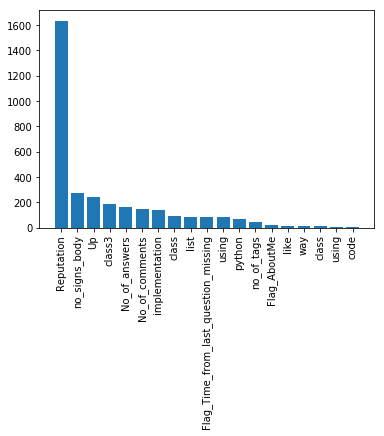

In [62]:
from sklearn.externals import joblib 
xgb_model=pipeline_9.fit(X_train,y_train)


num_names = dict(xgb_model.named_steps['union'].transformer_list).get('num_pipeline').named_steps['selector'].get_feature_names()
#print(num_names)
#cat_names = dict(xgb_model.named_steps['union'].transformer_list).get('cat_pipeline').named_steps['vectorizer'].get_feature_names()
#print(cat_names)
txt_title_names = dict(xgb_model.named_steps['union'].transformer_list).get('txt_title_pipeline').named_steps['tfidf1'].get_feature_names()
print(txt_title_names)
txt_tag_names = dict(xgb_model.named_steps['union'].transformer_list).get('txt_tag_pipeline').named_steps['tfidf'].get_feature_names()
print(txt_tag_names)
#txt_body_names = dict(xgb_model.named_steps['union'].transformer_list).get('txt_body_pipeline').named_steps['tfidf'].get_feature_names()
#print(txt_body_names)
# names = pd.DataFrame(list(dict(enumerate(num_names+cat_names+txt_body_names+txt_tag_names)).items()), columns=['id','feature'])
# names['feature_id']="f"+names['id'].astype('str')
names = pd.DataFrame(list(dict(enumerate(num_names+txt_title_names+txt_tag_names)).items()), columns=['id','feature'])
names['feature_id']="f"+names['id'].astype('str')
#names.info()
print(names)
#feature_names = pipeline.named_steps['union'].get_feature_names()
#print('',fnames)
xgb_importance=pd.DataFrame(list(CV_clf_9.best_estimator_.named_steps["clf"].get_booster().get_fscore().items()),
columns=['feature_id','importance']).sort_values('importance', ascending=False)

final = pd.merge(xgb_importance, names, on='feature_id', how='left')
print('',final)


indices = np.argsort(final.importance)[::-1]
#print(indices)
# Rearrange feature names so they match the sorted feature importances
names = [final.feature[i] for i in indices]
#print(names)
#print(range(len(final)))
plt.bar(range(len(final)), final.importance[indices])

# Add feature names as x-axis labels
plt.xticks(range(len(final)), names,rotation=90)
plt.figure(figsize=(9, 6))
# Show plot
plt.show()
#xgb_fea_imp.to_csv('xgb_fea_imp.csv')
#type(xgb_model)
# print(CV_clf.best_estimator_.named_steps["clf"].feature_importances_)
#print(CV_clf.best_estimator_.named_steps["clf"].get_booster().get_fscore())
# from xgboost import plot_importance
# plot_importance(xgb_model, )

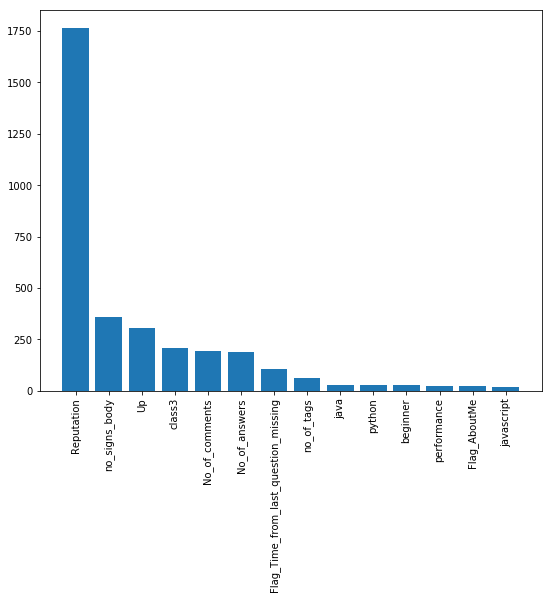

In [76]:
from sklearn.externals import joblib 
xgb_model=pipeline_5.fit(X_train,y_train)


num_names = dict(xgb_model.named_steps['union'].transformer_list).get('num_pipeline').named_steps['selector'].get_feature_names()
#print(num_names)
#cat_names = dict(xgb_model.named_steps['union'].transformer_list).get('cat_pipeline').named_steps['vectorizer'].get_feature_names()
#print(cat_names)
#txt_title_names = dict(xgb_model.named_steps['union'].transformer_list).get('txt_title_pipeline').named_steps['tfidf'].get_feature_names()
#print(txt_title_names)
txt_tag_names = dict(xgb_model.named_steps['union'].transformer_list).get('txt_tag_pipeline').named_steps['tfidf'].get_feature_names()
# print(txt_tag_names)
#txt_body_names = dict(xgb_model.named_steps['union'].transformer_list).get('txt_body_pipeline').named_steps['tfidf'].get_feature_names()
#print(txt_tag_names)
# names = pd.DataFrame(list(dict(enumerate(num_names+cat_names+txt_body_names+txt_tag_names)).items()), columns=['id','feature'])
# names['feature_id']="f"+names['id'].astype('str')
names = pd.DataFrame(list(dict(enumerate(num_names+txt_tag_names)).items()), columns=['id','feature'])
names['feature_id']="f"+names['id'].astype('str')
#names.info()
#print(names)
#feature_names = pipeline.named_steps['union'].get_feature_names()
#print('',fnames)
xgb_importance=pd.DataFrame(list(CV_clf_5.best_estimator_.named_steps["clf"].get_booster().get_fscore().items()),
columns=['feature_id','importance']).sort_values('importance', ascending=False)

final = pd.merge(xgb_importance, names, on='feature_id', how='left')
#print('',final)


indices = np.argsort(final.importance)[::-1]
#print(indices)
# Rearrange feature names so they match the sorted feature importances
names = [final.feature[i] for i in indices]
#print(names)
#print(range(len(final)))
plt.bar(range(len(final)), final.importance[indices])

# Add feature names as x-axis labels
plt.xticks(range(len(final)), names,rotation=90)
plt.gcf().set_size_inches(9, 7)
# Show plot
#plt.show()
plt.savefig("/home/adam/bigdata/dane/codereview/Clssifier_5.png",bbox_inches='tight')
#xgb_fea_imp.to_csv('xgb_fea_imp.csv')
#type(xgb_model)
# print(CV_clf.best_estimator_.named_steps["clf"].feature_importances_)
#print(CV_clf.best_estimator_.named_steps["clf"].get_booster().get_fscore())
# from xgboost import plot_importance
# plot_importance(xgb_model, )

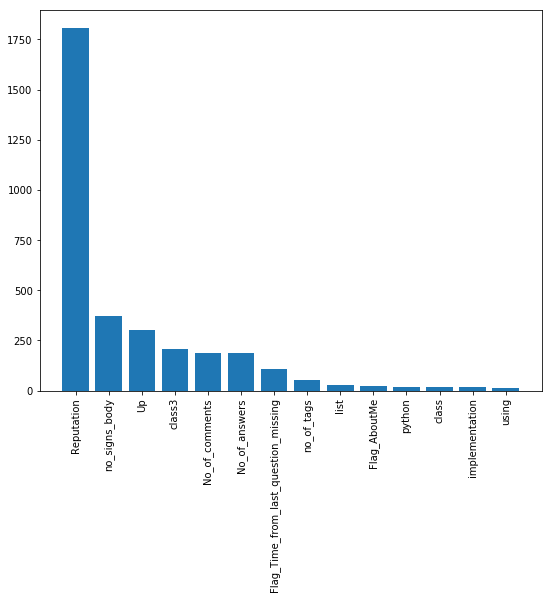

In [75]:
from sklearn.externals import joblib 
xgb_model=pipeline_6.fit(X_train,y_train)


num_names = dict(xgb_model.named_steps['union'].transformer_list).get('num_pipeline').named_steps['selector'].get_feature_names()
#print(num_names)
#cat_names = dict(xgb_model.named_steps['union'].transformer_list).get('cat_pipeline').named_steps['vectorizer'].get_feature_names()
#print(cat_names)
txt_title_names = dict(xgb_model.named_steps['union'].transformer_list).get('txt_title_pipeline').named_steps['tfidf'].get_feature_names()
#print(txt_title_names)
# txt_tag_names = dict(xgb_model.named_steps['union'].transformer_list).get('txt_tag_pipeline').named_steps['tfidf'].get_feature_names()
# print(txt_tag_names)
# names = pd.DataFrame(list(dict(enumerate(num_names+cat_names+txt_body_names+txt_tag_names)).items()), columns=['id','feature'])
# names['feature_id']="f"+names['id'].astype('str')
names = pd.DataFrame(list(dict(enumerate(num_names+txt_title_names)).items()), columns=['id','feature'])
names['feature_id']="f"+names['id'].astype('str')
#names.info()
#print(names)
#feature_names = pipeline.named_steps['union'].get_feature_names()
#print('',fnames)
xgb_importance=pd.DataFrame(list(CV_clf_6.best_estimator_.named_steps["clf"].get_booster().get_fscore().items()),
columns=['feature_id','importance']).sort_values('importance', ascending=False)

final = pd.merge(xgb_importance, names, on='feature_id', how='left')
#print('',final)


indices = np.argsort(final.importance)[::-1]
#print(indices)
# Rearrange feature names so they match the sorted feature importances
names = [final.feature[i] for i in indices]
#print(names)
#print(range(len(final)))
plt.bar(range(len(final)), final.importance[indices])

# Add feature names as x-axis labels
plt.xticks(range(len(final)), names,rotation=90)
plt.gcf().set_size_inches(9, 7)
# Show plot
plt.savefig("/home/adam/bigdata/dane/codereview/Clssifier_6.png",bbox_inches='tight')
#xgb_fea_imp.to_csv('xgb_fea_imp.csv')
#type(xgb_model)
# print(CV_clf.best_estimator_.named_steps["clf"].feature_importances_)
#print(CV_clf.best_estimator_.named_steps["clf"].get_booster().get_fscore())
# from xgboost import plot_importance
# plot_importance(xgb_model, )

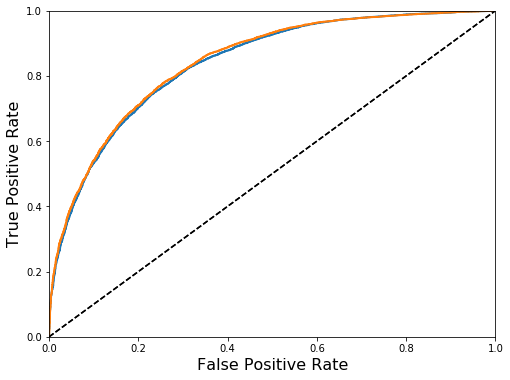

In [24]:
y_pred_1 = CV_clf_1.best_estimator_.predict_proba(X_test)[:,1]
y_pred_2 = CV_clf_2.best_estimator_.predict_proba(X_test)[:,1]
# y_pred_2 = CV_clf_2.best_estimator_.predict_proba(X_test)[:,1]
# y_pred_2 = CV_clf_2.best_estimator_.predict_proba(X_test)[:,1]
#y_pred =  pipeline.predict(X_test)
#print(classification_report(y_test, y_pred,digits=3))

from sklearn.metrics import roc_curve

fpr_1, tpr_1, thresholds = roc_curve(y_test, y_pred_1)
fpr_2, tpr_2, thresholds = roc_curve(y_test, y_pred_2)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_1, tpr_1)
plot_roc_curve(fpr_2, tpr_2)
# save_fig("roc_curve_plot")
plt.show()

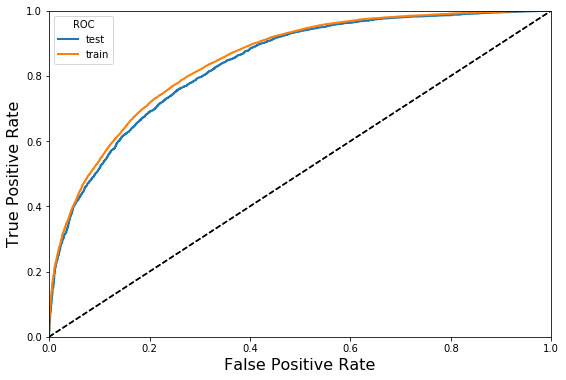

In [74]:
y_pred_5 = CV_clf_5.best_estimator_.predict_proba(X_test)[:,1]
y_pred_train_5 = CV_clf_5.best_estimator_.predict_proba(X_train)[:,1]
# y_pred_2 = CV_clf_2.best_estimator_.predict_proba(X_test)[:,1]
# y_pred_2 = CV_clf_2.best_estimator_.predict_proba(X_test)[:,1]
#y_pred =  pipeline.predict(X_test)
#print(classification_report(y_test, y_pred,digits=3))

from sklearn.metrics import roc_curve

fpr_1, tpr_1, thresholds = roc_curve(y_test, y_pred_5)
fpr_2, tpr_2, thresholds = roc_curve(y_train, y_pred_train_5)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend(title = 'ROC')

plt.figure(figsize=(9, 6))

plot_roc_curve(fpr_1, tpr_1,label='test')
plot_roc_curve(fpr_2, tpr_2,label='train')
plt.savefig("/home/adam/bigdata/dane/codereview/ROC2_5.png",bbox_inches='tight')
#plt.show()

In [48]:
y_pred_1 = CV_clf_1.best_estimator_.predict_proba(X_test)[:,1]
y_pred_2 = CV_clf_2.best_estimator_.predict_proba(X_test)[:,1]
y_pred_3 = CV_clf_3.best_estimator_.predict_proba(X_test)[:,1]
y_pred_4 = CV_clf_4.best_estimator_.predict_proba(X_test)[:,1]
y_pred_5 = CV_clf_5.best_estimator_.predict_proba(X_test)[:,1]
y_pred_6 = CV_clf_6.best_estimator_.predict_proba(X_test)[:,1]
y_pred_7 = CV_clf_7.best_estimator_.predict_proba(X_test)[:,1]
y_pred_8 = CV_clf_8.best_estimator_.predict_proba(X_test)[:,1]
y_pred_9 = CV_clf_9.best_estimator_.predict_proba(X_test)[:,1]
y_pred_10 = CV_clf_10.best_estimator_.predict_proba(X_test)[:,1]
y_pred_11 = CV_clf_11.best_estimator_.predict_proba(X_test)[:,1]
y_pred_12 = CV_clf_12.best_estimator_.predict_proba(X_test)[:,1]

print(roc_auc_score(y_test, y_pred_1))
print(roc_auc_score(y_test, y_pred_2))
print(roc_auc_score(y_test, y_pred_3))
print(roc_auc_score(y_test, y_pred_4))
print(roc_auc_score(y_test, y_pred_5))
print(roc_auc_score(y_test, y_pred_6))
print(roc_auc_score(y_test, y_pred_7))
print(roc_auc_score(y_test, y_pred_8))
print(roc_auc_score(y_test, y_pred_9))
print(roc_auc_score(y_test, y_pred_10))
print(roc_auc_score(y_test, y_pred_11))
print(roc_auc_score(y_test, y_pred_12))


y_pred__train_1 = CV_clf_1.best_estimator_.predict_proba(X_train)[:,1]
y_pred_2 = CV_clf_2.best_estimator_.predict_proba(X_train)[:,1]
y_pred_3 = CV_clf_3.best_estimator_.predict_proba(X_train)[:,1]
y_pred_4 = CV_clf_4.best_estimator_.predict_proba(X_train)[:,1]
y_pred_5 = CV_clf_5.best_estimator_.predict_proba(X_train)[:,1]
y_pred_6 = CV_clf_6.best_estimator_.predict_proba(X_train)[:,1]
y_pred_7 = CV_clf_7.best_estimator_.predict_proba(X_train)[:,1]
y_pred_8 = CV_clf_8.best_estimator_.predict_proba(X_train)[:,1]
y_pred_9 = CV_clf_9.best_estimator_.predict_proba(X_train)[:,1]
y_pred_10 = CV_clf_10.best_estimator_.predict_proba(X_train)[:,1]
y_pred_11 = CV_clf_11.best_estimator_.predict_proba(X_train)[:,1]
y_pred_12 = CV_clf_12.best_estimator_.predict_proba(X_train)[:,1]

print(roc_auc_score(y_train, y_pred__train_1))
print(roc_auc_score(y_train, y_pred_2))
print(roc_auc_score(y_train, y_pred_3))
print(roc_auc_score(y_train, y_pred_4))
print(roc_auc_score(y_train, y_pred_5))
print(roc_auc_score(y_train, y_pred_6))
print(roc_auc_score(y_train, y_pred_7))
print(roc_auc_score(y_train, y_pred_8))
print(roc_auc_score(y_train, y_pred_9))
print(roc_auc_score(y_train, y_pred_10))
print(roc_auc_score(y_train, y_pred_11))
print(roc_auc_score(y_train, y_pred_12))


0.8353115252145022
0.8344087392637496
0.8359782711519907
0.8332192549231467
0.8369953211984155
0.8375840792319293
0.8329317631498578
0.835284229448111
0.8061404873426983
0.8344878244001396
0.8335505347100529
0.7905845844990161
0.8469714451053951
0.8464193254048786
0.8476142199371195
0.8483748298759071
0.8480861395606042
0.847899990011256
0.8465750497970749
0.8469857382511038
0.8466311758194917
0.8505344051884415
0.8484982512102015
0.8492851834095023


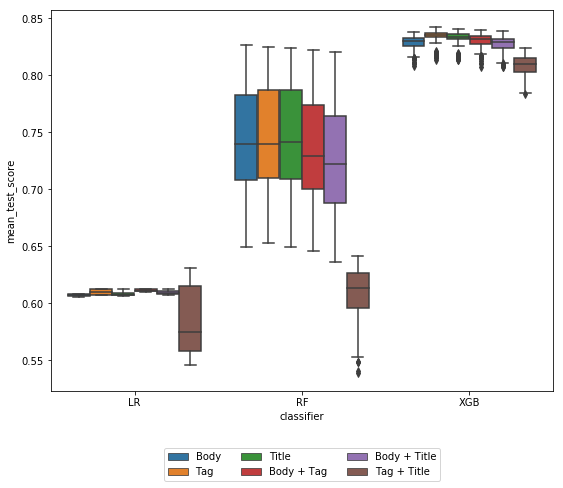

In [60]:
%matplotlib inline

g = sns.boxplot(x="classifier", hue='vars',y="mean_test_score", data=clf)
#g.legend(loc=3)
#g.fig.legend(loc='upper center', ncol=1)
# g.legend(loc='lower center', bbox_to_anchor=(1.5, 0.5), ncol=1)
g.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25),ncol=3)
plt.gcf().set_size_inches(9, 7)
#plt.tight_layout()
plt.savefig("/home/adam/bigdata/dane/codereview/Clssifier_vars.png",bbox_inches='tight')

/home/adam/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


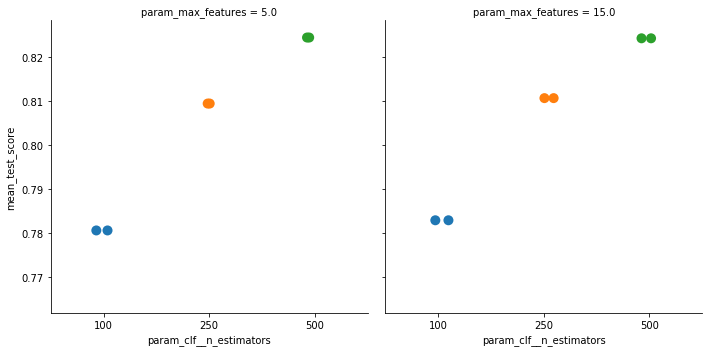

In [70]:

# %matplotlib inline
# plt.figure(figsize=(9,6))
# g = sns.boxplot(x="classifier", hue='txt',y="mean_test_score", data=clf)
# #g.legend(loc=3)
# #g.fig.legend(loc='upper center', ncol=1)
# # g.legend(loc='lower center', bbox_to_anchor=(1.5, 0.5), ncol=1)
# g.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5),ncol=2)
# plt.tight_layout()
# plt.savefig("/home/adam/bigdata/dane/codereview/Clssifier_txt.png",bbox_inches='tight')




df1 = pd.read_excel(open('/home/adam/bigdata/dane/codereview/tuning4.xlsx','rb'), sheet_name='Sheet1')
df1.head()

# scores_lr = scores[scores['param_clf'].astype('str').str.contains('LogisticRegression')]
# scores_lr.rename(columns={'param_union__txt_pipeline__tfidf__ngram_range':'param_ngram_range'}, inplace=True)

# scores_gb = scores[scores['param_clf'].astype('str').str.contains('GradientBoostingClassifier')]
# scores_gb.rename(columns={'param_union__txt_pipeline__tfidf__ngram_range':'param_ngram_range'}, inplace=True)
# scores_gb.head()

# scores_rf = scores[scores['param_clf'].astype('str').str.contains('RandomForestClassifier')]
# scores_rf.rename(columns={'param_union__txt_pipeline__tfidf__ngram_range':'param_ngram_range'}, inplace=True)
# scores_rf.head(30)

 
scores_xgb = df1[(df1['classifier']=='XGB') & (df1['full']=='Body + CountVectorizer') ]
scores_xgb.rename(columns={'param_union__txt_pipeline__tfidf__ngram_range':'param_ngram_range',
                          'param_union__txt_body_pipeline__tfidf__max_features':'param_max_features'}, inplace=True)
scores_xgb.head(30)
#scores_xgb.info()

# %matplotlib inline
# g1 = sns.catplot(x='param_clf__C', y='mean_test_score',
#                 col = 'param_ngram_range',
#                hue='param_clf__penalty',s=10,
#                data=scores_lr);

# %matplotlib inline
# g2 = sns.catplot(x='param_clf__n_estimators', y='mean_test_score',
#                 col = 'param_ngram_range',
#                hue='param_clf__max_depth',s=10,
#                data=scores_gb);

%matplotlib inline
g2 = sns.catplot(x='param_clf__n_estimators', y='mean_test_score',
                col = 'param_max_features',
               s=10,legend = False,legend_out = False,
               data=scores_xgb);
#plt.legend(loc='lower center', bbox_to_anchor=(-0.5, -0.3),ncol=4,title='param_clf_max_depth')
#plt.tight_layout()
plt.savefig("/home/adam/bigdata/dane/codereview/Clssifier_parameters2.png",bbox_inches='tight')

columny=['class1','Up','No_of_answers','No_of_comments']
print(y_train.shape)   
print(X_train[columny].head())   

gbc = GradientBoostingClassifier()
param_grid = { 
    'n_estimators': [10,30,50, 70,100],
    'learning_rate': [0.05,0.1,0.2,0.5],
    'max_depth':[3,5]
    #'max_features': ['auto', 'sqrt', 'log2']
}

CV_gbc = GridSearchCV(estimator=gbc, param_grid=param_grid, cv= 3,scoring = 'f1')
CV_gbc.fit(X_train[columny] , y_train)
print('Grid best parameter (max. AUC): ', CV_gbc.best_params_)
print('Grid best score (AUC): ', CV_gbc.best_score_)
print( CV_gbc)
CV_gbc.grid_scores_

In [63]:
print('Grid best parameter (max. AUC): ', CV_clf_5.best_params_)
print('Grid best score (AUC): ', CV_clf_5.best_score_)
#print( CV_clf_1)
print('Grid best parameter (max. AUC): ', CV_clf_6.best_params_)
print('Grid best score (AUC): ', CV_clf_6.best_score_)
#print( CV_clf_4)
print('Grid best parameter (max. AUC): ', CV_clf_9.best_params_)
print('Grid best score (AUC): ', CV_clf_9.best_score_)
#print( CV_clf_11)

Grid best parameter (max. AUC):  {'clf': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=4, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1), 'clf__min_child_weight': 4, 'clf__n_estimators': 500, 'union__txt_tag_pipeline__tfidf__max_features': 5, 'union__txt_tag_pipeline__tfidf__ngram_range': (1, 1)}
Grid best score (AUC):  0.8279584681974534
Grid best parameter (max. AUC):  {'clf': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=4, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, sc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 6 columns):
Unnamed: 0    90 non-null int64
id            90 non-null int64
diet          90 non-null category
pulse         90 non-null int64
time          90 non-null category
kind          90 non-null category
dtypes: category(3), int64(3)
memory usage: 2.7 KB


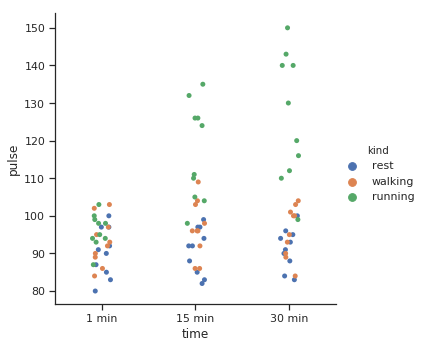

In [67]:
import seaborn as sns
sns.set(style="ticks")
exercise = sns.load_dataset("exercise")
exercise.info()
g = sns.catplot(x="time", y="pulse", hue="kind", data=exercise)

In [77]:
import seaborn as sns
tips = sns.load_dataset("tips")
tips.info()
# sns.catplot(x="day", y="total_bill", hue="smoker",
#             col="time", aspect=.6,
#             kind="swarm", data=tips);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
total_bill    244 non-null float64
tip           244 non-null float64
sex           244 non-null category
smoker        244 non-null category
day           244 non-null category
time          244 non-null category
size          244 non-null int64
dtypes: category(4), float64(2), int64(1)
memory usage: 7.2 KB


In [ ]:

num_names = dict(xgb_model.named_steps['union'].transformer_list).get('num_pipeline').named_steps['selector'].get_feature_names()
txt_tag_names = dict(xgb_model.named_steps['union'].transformer_list).get('txt_tag_pipeline').named_steps['tfidf'].get_feature_names()
names = pd.DataFrame(list(dict(enumerate(num_names+txt_tag_names)).items()), columns=['id','feature'])
names['feature_id']="f"+names['id'].astype('str')
xgb_importance=pd.DataFrame(list(CV_clf_5.best_estimator_.named_steps["clf"].get_booster().get_fscore().items()),
columns=['feature_id','importance']).sort_values('importance', ascending=False)
final = pd.merge(xgb_importance, names, on='feature_id', how='left')
indices = np.argsort(final.importance)[::-1]
names = [final.feature[i] for i in indices]
plt.bar(range(len(final)), final.importance[indices])
plt.xticks(range(len(final)), names,rotation=90)
plt.gcf().set_size_inches(9, 7)
plt.savefig("/home/adam/bigdata/dane/codereview/Clssifier_5.png",bbox_inches='tight')